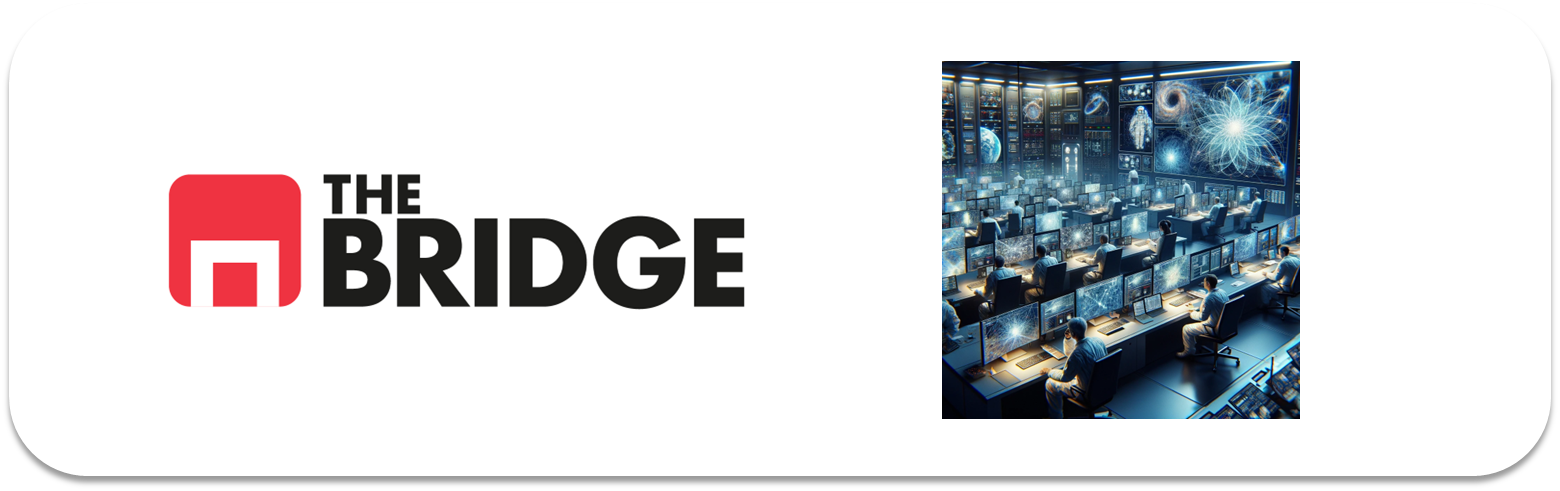

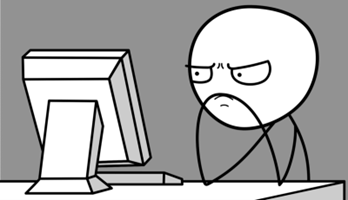

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [103]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras



from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models


## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [2]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [7]:
ROOT_PATH = './data/apples/'
TRAIN_PATH = ROOT_PATH + 'train/'
TEST_PATH = ROOT_PATH + 'test/'

In [8]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

Braeburn
CrimsonSnow
Golden1
Golden2
Golden3
GrannySmith
PinkLady
Red1
Red2
Red3
RedDelicious
RedYellow1
RedYellow2
Braeburn
CrimsonSnow
Golden1
Golden2
Golden3
GrannySmith
PinkLady
Red1
Red2
Red3
RedDelicious
RedYellow1
RedYellow2


In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6404, 32, 32, 3)
(6404,)
(2134, 32, 32, 3)
(2134,)


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

In [10]:
def show_images_batch(manzanas, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(manzanas) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(manzanas):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

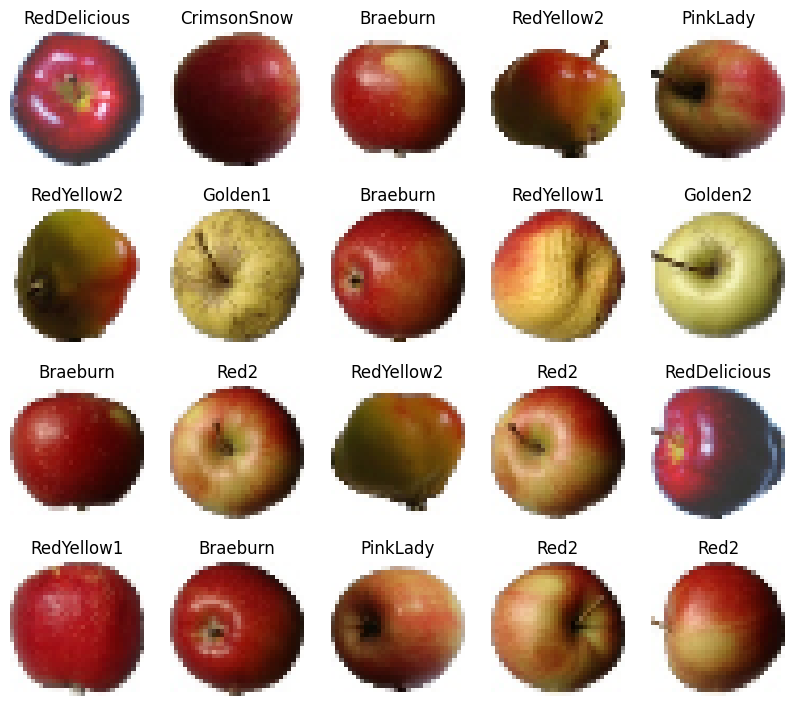

In [11]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

Text(0.5, 0, 'Braeburn')

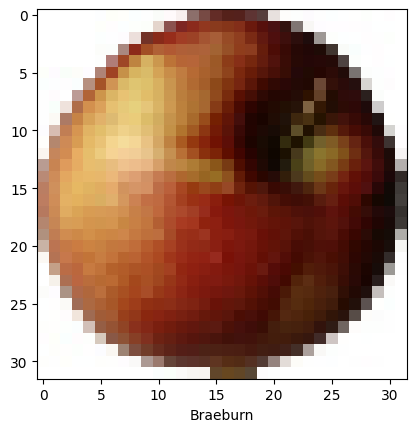

In [13]:
plt.imshow(X_train[255])
plt.xlabel(y_train[255])

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [22]:
target = pd.Series(y_train)
target.value_counts(True) * 100

RedYellow2      10.493442
Golden2          7.682698
Red2             7.682698
GrannySmith      7.682698
Braeburn         7.682698
RedYellow1       7.682698
Red1             7.682698
RedDelicious     7.651468
Golden3          7.510931
Golden1          7.495315
PinkLady         7.120550
CrimsonSnow      6.933167
Red3             6.698938
Name: proportion, dtype: float64

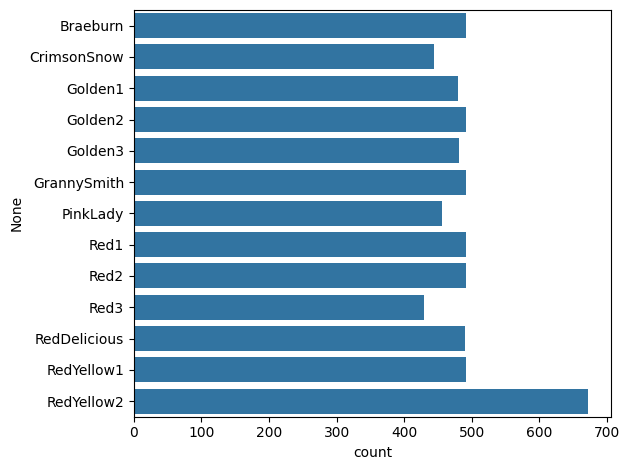

In [ ]:
import seaborn as sns
sns.countplot(y = target)
plt.tight_layout()


### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [23]:
X_train = X_train/255
X_test = X_test/255

In [24]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

Text(0.5, 0, 'Braeburn')

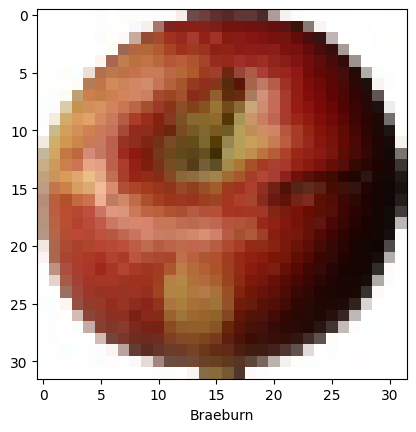

In [25]:
plt.imshow(X_train[255])
plt.xlabel(y_train[255])

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [37]:
lista = {}
n = 0
for x in target.unique():
    lista[x] = n
    n += 1

lista


{'Braeburn': 0,
 'CrimsonSnow': 1,
 'Golden1': 2,
 'Golden2': 3,
 'Golden3': 4,
 'GrannySmith': 5,
 'PinkLady': 6,
 'Red1': 7,
 'Red2': 8,
 'Red3': 9,
 'RedDelicious': 10,
 'RedYellow1': 11,
 'RedYellow2': 12}

In [40]:
lista.keys()

dict_keys(['Braeburn', 'CrimsonSnow', 'Golden1', 'Golden2', 'Golden3', 'GrannySmith', 'PinkLady', 'Red1', 'Red2', 'Red3', 'RedDelicious', 'RedYellow1', 'RedYellow2'])

In [56]:
y_train_num = np.array([lista[cat] for cat in y_train])
y_test_num = np.array([lista[cat] for cat in y_test])

In [58]:
np.unique(y_train_num)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [60]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input


base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

In [61]:
def read_data(directorio, reshape_dim = (224,224)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [62]:
X_test_224, y_test_224 = read_data(TEST_PATH)

Braeburn
CrimsonSnow
Golden1
Golden2
Golden3
GrannySmith
PinkLady
Red1
Red2
Red3
RedDelicious
RedYellow1
RedYellow2


In [63]:
aleatorio = np.random.randint(0, len(X_test_224), 20)
predictions = base_model.predict(X_test_224[aleatorio])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


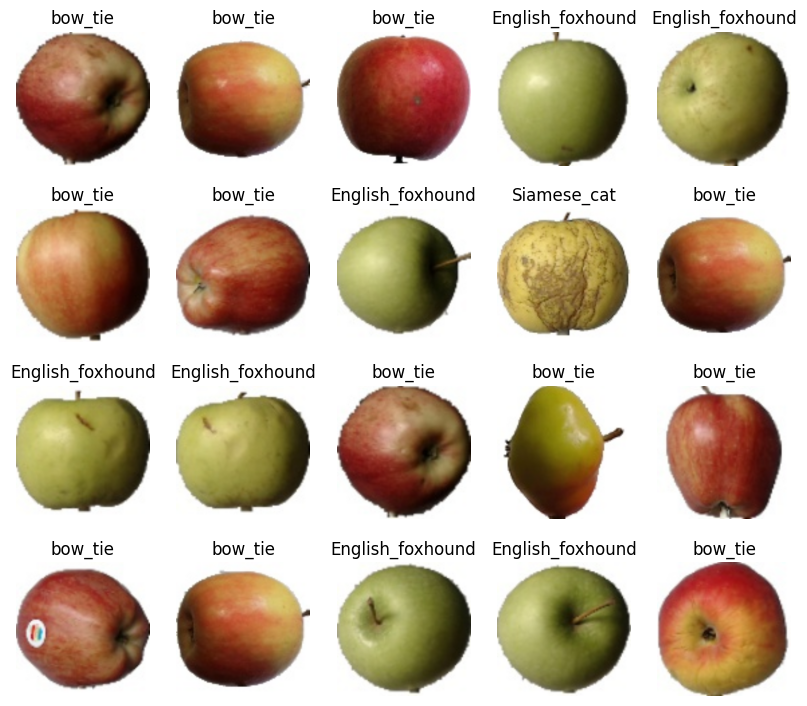

In [71]:
decodes = decode_predictions(predictions)
clase = [decodificado[0][1] for decodificado in decodes]
show_images_batch(X_test_224[aleatorio], names=clase)

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [80]:
base_model_transfer = ResNet50V2(input_shape=(32, 32,3),
                        include_top=False, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights="imagenet" # Se carga con los pesos entrenados para el dataset de imagenet
                        )

- congelacion de las capas para que no se entrenen de nuevo

In [81]:
for layer in base_model_transfer.layers:
    layer.trainable = False

In [86]:
x = layers.Flatten()(base_model_transfer.output)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(13, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model_transfer.input, x)

model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [90]:
len(X_train)/32


200.125

In [ ]:
from keras.callbacks import EarlyStopping
earlyS = keras.callbacks.EarlyStopping(patience= 5, restore_best_weights= True)

In [93]:
history  = model.fit(X_train, y_train_num, batch_size=32, epochs=20, callbacks=[earlyS], validation_split=0.2)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.5046 - loss: 1.9981 - val_accuracy: 0.9360 - val_loss: 0.2213
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9139 - loss: 0.2766 - val_accuracy: 0.9883 - val_loss: 0.0860
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9569 - loss: 0.1500 - val_accuracy: 0.9883 - val_loss: 0.0608
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9780 - loss: 0.0879 - val_accuracy: 0.9969 - val_loss: 0.0259
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9902 - loss: 0.0486 - val_accuracy: 0.9992 - val_loss: 0.0190
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.9829 - loss: 0.0558 - val_accuracy: 0.9992 - val_loss: 0.0156
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.9864 - loss: 0.0496 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9875 - loss: 0

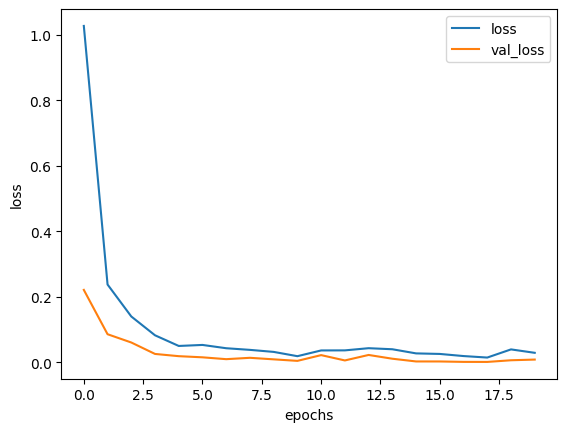

In [94]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

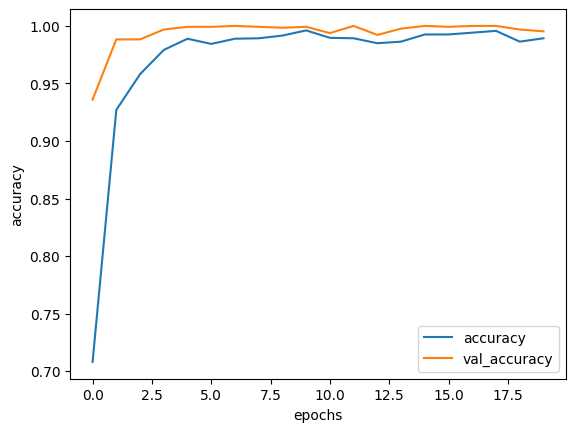

In [95]:
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [97]:
model.evaluate(X_test,y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8747 - loss: 0.4642


[0.5383135676383972, 0.8603561520576477]

In [99]:
from sklearn.metrics import classification_report
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]

print(classification_report(y_test_num,y_pred))

67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       164
           1       0.76      0.89      0.82       148
           2       0.84      0.99      0.91       160
           3       1.00      0.87      0.93       164
           4       0.67      0.75      0.71       161
           5       1.00      0.80      0.89       164
           6       0.81      0.79      0.80       152
           7       0.93      0.88      0.90       164
           8       0.63      0.67      0.65       164
           9       0.99      0.69      0.82       144
          10       1.00      1.00      1.00       166
          11       0.95      0.97      0.96       164
          12       1.00      0.96      0.98       219

    accuracy                           0.86      2134
   macro avg       0.87      0.86      0.86      2134
weighted avg       0.87      0.86      0.86      2134



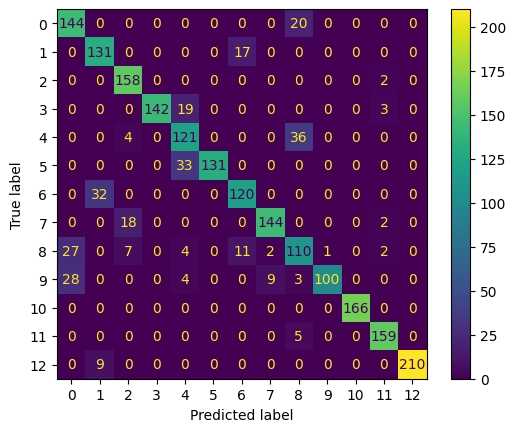

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred)

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [108]:
base_model = ResNet50V2(input_shape=(32, 32,3),
                        include_top=False,
                         weights = None # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        )

for layer in base_model_transfer.layers:
    layer.trainable = False

x = layers.Flatten()(base_model_transfer.output)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(13, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model_transfer.input, x)

model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [109]:
earlyS = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)

In [110]:
history_fine  = model.fit(X_train, y_train_num, batch_size=64, epochs=60, callbacks=[earlyS], validation_split=0.2)

Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.4922 - loss: 1.7573 - val_accuracy: 0.9524 - val_loss: 0.2497
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.8903 - loss: 0.3558 - val_accuracy: 0.9836 - val_loss: 0.1038
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.9457 - loss: 0.1929 - val_accuracy: 0.9696 - val_loss: 0.1015
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9682 - loss: 0.1181 - val_accuracy: 0.9984 - val_loss: 0.0387
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.9798 - loss: 0.0774 - val_accuracy: 0.9984 - val_loss: 0.0231
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.9883 - loss: 0.0582 - val_accuracy: 0.9977 - val_loss: 0.0202
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.9905 - loss: 0.0447 - val_accuracy: 0.9992 - val_loss: 0.0116
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.9954 - loss: 0.0291 - val_accu

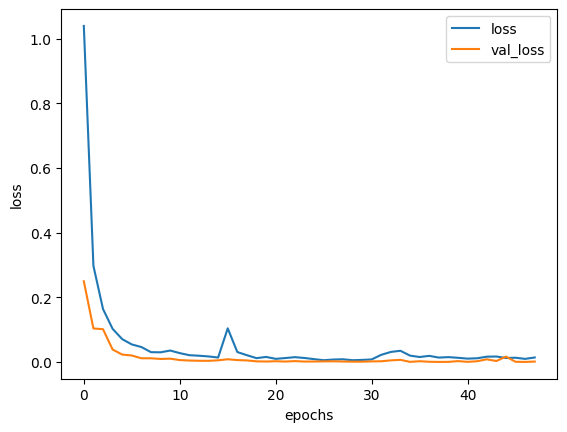

In [112]:
history_fine = pd.DataFrame(history_fine.history)
history_fine[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [111]:
model.evaluate(X_test,y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8980 - loss: 0.4262


[0.5105857849121094, 0.8922211527824402]

In [113]:
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]

print(classification_report(y_test_num,y_pred))

67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       164
           1       0.98      0.91      0.94       148
           2       0.81      0.98      0.89       160
           3       0.98      0.95      0.97       164
           4       0.69      0.70      0.70       161
           5       0.99      0.80      0.89       164
           6       0.86      0.99      0.92       152
           7       1.00      0.84      0.91       164
           8       0.65      0.77      0.70       164
           9       1.00      0.74      0.85       144
          10       1.00      1.00      1.00       166
          11       0.98      0.99      0.98       164
          12       0.99      1.00      0.99       219

    accuracy                           0.89      2134
   macro avg       0.90      0.89      0.89      2134
weighted avg       0.90      0.89      0.89      2134

